In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
import statsmodels.formula.api as smf
from bson import ObjectId
from pymongo import MongoClient
import matplotlib as mpl
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
client = MongoClient('127.0.0.1', 27017)
db = client.moniter_crowdfunding
# db.authenticate(name="worker", password="hard", mechanism="SCRAM-SHA-1")

In [3]:
db.list_collection_names()

['projects',
 'companies',
 'success_projects',
 'front_page',
 'sucess_projects',
 'failure_projects',
 'founders']

In [4]:
project = db.projects
s_project = db.success_projects
f_project = db.failure_projects
front_page = db.front_page
company = db.companies

In [5]:
num_Psucc = s_project.count_documents({'状态': '项目成功'})
num_Csucc = project.count_documents({'状态': '众筹成功'})
num_Cing = project.count_documents({'状态': '众筹中'})
num_Pheat = project.count_documents({'状态': '预热中'})
num_Fproj = f_project.count_documents({})
print(f'项目成功:{num_Psucc}', f'众筹成功:{num_Csucc}', 
      f'众筹中:{num_Cing}', f'预热中:{num_Pheat}', f'项目失败:{num_Fproj}', sep='\t')

项目成功:4160	众筹成功:133	众筹中:95	预热中:10	项目失败:3040


In [422]:
s_project.find_one({}, projection={'项目动态信息': False, '各档动态信息': False, '评论': False})

{'_id': '100010',
 '众筹期限': 45,
 '公司地址': '广东广州市白云区\xa0\xa0机场路1630号白云时光227室',
 '状态变换时间1-2': datetime.datetime(2018, 4, 30, 10, 0, 20, 247000),
 '各档基础信息': {'1': {'lim_num': None,
   'deliver_info': '预计回报发送时间：项目众筹成功后30天内',
   'sup_price': 399,
   'redound_info': '感谢您的支持！您将以399元价格获得手工打造街头潮流的运动跨界鞋1双（颜色：枣红色，天蓝色，草绿色，卡其色，深灰色 ）。'},
  '2': {'lim_num': None,
   'deliver_info': '预计回报发送时间：项目众筹成功后30天内',
   'sup_price': 429,
   'redound_info': '感谢您的支持！您将以429元的价格获得手工打造街头潮流的运动跨界鞋1双+加厚鞋垫1对。（颜色：枣红色，天蓝色，草绿色，卡其色，深灰色 ）。'},
  '0': {'lim_num': None,
   'deliver_info': '预计回报发送时间：项目众筹成功后30天内',
   'sup_price': 39,
   'redound_info': '感谢您的支持！您将以39元的价格获得加厚鞋垫1对。'}},
 '爬取次数': 555,
 '项目名称': '一双街头潮流与运动的跨界鞋',
 '所属类别': '原创设计',
 '状态': '项目成功',
 '公司电话': '0760-87826716',
 '状态变换时间0-1': datetime.datetime(2018, 4, 28, 10, 11, 6, 382000),
 '目标金额': 50000,
 '发起人链接': '/funderCenter.action?flag=2&id=100010',
 '公司工作时间': '工作日 09:00-18:00',
 '公司名称': '广州粤脉文化发展有限公司',
 '发起人名称': '粤脉电商视觉设计',
 '状态变换时间2-3': datetime.datetime(2018, 6, 14, 20, 

## 1. 项目数据转换

按照项目更新时间将项目动态信息转换为`pd.DataFrame()`

In [17]:
def to_df(item):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
        
    # 根据更新时间去除重复
    a1 = dyn_info[0]
    records = {'更新时间':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间'] or a2["完成百分比"] != a1["完成百分比"]:  # 有些时候，更新时间相同但是完成百分比不相同
            records['更新时间'].append(a2['更新时间'])
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            a1 = a2

    col_names = ['关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

In [170]:
item = s_project.find_one({"_id": '100031'}, projection={'状态变换时间0-1': True, '状态变换时间1-2': True, '状态变换时间2-3': True, 
                                          '状态变换时间3-4': True, '众筹期限': True, 
                                          "项目动态信息": True, "目标金额": True})
dyn_df = to_df(item)
dyn_df

,关注数,支持者数,点赞数,完成百分比,筹集金额
2018-04-28 11:15:31,18,0,9,0.0,0
2018-04-28 15:35:24,19,0,9,0.0,0
2018-04-28 19:59:44,20,0,9,0.0,0
2018-04-30 07:12:24,21,0,9,0.0,0
2018-05-02 01:34:40,22,0,9,0.0,0
...,...,...,...,...,...
2018-05-29 23:18:46,592,494,556,254.0,253906
2018-05-30 17:54:52,592,495,557,254.0,254405
2018-05-31 10:43:28,593,496,557,255.0,254904
2018-05-31 18:26:44,596,496,557,255.0,254904


In [172]:
item['状态变换时间2-3'].timestamp()

1527923157.489

In [178]:
f_index = np.array([x.timestamp() for x in dyn_df.index.to_pydatetime()]) < 152792315
dyn_df[f_index].iloc[-1]

IndexError: single positional indexer is out-of-bounds

In [128]:
dyn_df[dyn_df.index.to_pydatetime() < item['状态变换时间1-2']]

,关注数,支持者数,点赞数,完成百分比,筹集金额
2018-04-28 11:05:59,19,0,4,0.0,0
2018-04-28 12:33:39,20,0,4,0.0,0
2018-04-28 15:40:45,22,0,4,0.0,0
2018-04-28 19:31:13,23,0,4,0.0,0
2018-04-28 22:58:43,24,0,4,0.0,0
2018-04-29 00:07:04,24,0,4,0.0,0
2018-04-29 04:30:06,25,0,4,0.0,0
2018-04-29 06:53:51,26,0,4,0.0,0
2018-04-29 09:08:07,28,0,4,0.0,0
2018-04-29 19:25:09,31,0,4,0.0,0


### 1.1 获取众筹期间项目在主页各位置的展示时长和初始状态

以项目编号为键，记录各项目记录在主页中出现的时间和位置。
> 项目在列表中，因此只要将列表中的值反转即可得到项目的位置和时间。

然后，找出对应每个项目出现在主页上的时间。

以项目众筹开始时间为参考时间，分析平台将项目呈现在主页各版块的初次时间。

- 第1次出现在“即将上架”时间 - 状态变换0-1
- 第1次出现在“最新上架”时间 - 状态变换1-2
- 第1次出现在“轮播”时间 - 状态变换1-2
- 第1次出现在“各类板块”时间 - 状态变换1-2
- 第1次出现在“热门推荐”时间 - 状态变换1-2
- 状态变换2-3 - 第1次出现在“即将结束”时间

In [388]:
top_keys = ['轮播', '即将上架', 'demostr_proj', '即将结束', '热门推荐', '最新上架']

In [389]:
keys = []
f_page = front_page.find_one()
for key1 in f_page:
    if key1 in ('即将上架', '最新上架', '热门推荐', '即将结束'):
        keys.append(key1)
    elif key1 == '轮播':
        for key2 in f_page[key1]:
            keys.append(key1 + '_' + key2)
    elif key1 == 'demostr_proj':
        for key2 in f_page[key1]:
            for key3 in f_page[key1][key2]:
                keys.append(key1 + '_' + key2 + '_' + key3)     

- 获取主页的版块信息作为键

In [390]:
new_dict = {}
for f_page in front_page.find():
    _id = f_page["_id"]  # _id 为 ObjectId
    for key1 in f_page:
        if key1 in ('即将上架', '最新上架', '热门推荐', '即将结束'):
            for p_id in f_page[key1]:
                if p_id in new_dict:
                    new_dict[p_id].append((key1, _id))
                else:
                    new_dict[p_id] = [(key1, _id)]
                    
        elif key1 == '轮播':
            for key2 in f_page[key1]:
                for p_id in f_page[key1][key2]:
                    if p_id in new_dict:
                        new_dict[p_id].append((key1 + '_' + key2, _id))
                    else:
                        new_dict[p_id] = [(key1 + '_' + key2, _id)]
                        
        elif key1 == 'demostr_proj':
            for key2 in f_page[key1]:
                for key3 in f_page[key1][key2]:
                    for p_id in f_page[key1][key2][key3]:
                        if p_id in new_dict:
                            new_dict[p_id].append((key1 + '_' + key2 + '_' + key3, _id))
                        else:
                            new_dict[p_id] = [(key1 + '_' + key2 + '_' + key3, _id)]

- 转换为以项目编号进行组织
```python
>>> item = s_project.find_one({"_id": "1818031176"}, projection={'项目动态信息': False, '各档动态信息': False, "评论": False})
>>> item['状态变换时间2-3'] - item['状态变换时间1-2']
datetime.timedelta(days=80, microseconds=601000)
```

In [221]:
item = f_project.find_one({"_id": "118900"})
# i_df = to_df(item)
# i_df.iloc[-1]

In [391]:
begin_keys = [*[f'begin_{k}' for k in keys],
             *[f'begin_{k}_完成百分比' for k in keys],
             *[f'begin_{k}_筹集金额' for k in keys],
             *[f'begin_{k}_关注数' for k in keys],
             *[f'begin_{k}_支持者数' for k in keys],
             *[f'begin_{k}_点赞数' for k in keys],
            ] # 存储信息呈现开始时刻的项目状态：完成百分比，支持者数，关注者数，距离众筹开始的时间长度
# begin_keys

- `res_dict`的数据格式:

> `热门推荐` 取 热门推荐 结束时间 减去 开始时间
```python
{'p_id':
 '热门推荐':
 ...
}
```

- `begin_res_dict`的数据格式:

> `begin_热门推荐` 取 *热门推荐* 开始时间 减去 众筹开始时间, *热门推荐_完成百分比*等 取 *热门推荐* 开始前的一个数据帧
```python
{'p_id':
 'begin_热门推荐': ,
 'begin_热门推荐_完成百分比': , 
 'begin_热门推荐_关注者数': ,
 'begin_热门推荐_筹集金额': ,
 'begin_热门推荐_支持者数': ,
 'begin_热门推荐_点赞数': ,
 'begin_轮播': ,
  ...
}

```


In [396]:
res_dict = {'p_id': [], **{key: [] for key in keys}}  # 存储项目的最终信息
begin_res_dict = {'p_id': [], **{key: [] for key in begin_keys}}  # 存储开始呈现时刻的项目动态信息
count_item_miss = 0
count_data_miss = 0
count_dfdata_miss = 0
count_other_error = 0
for p_id in new_dict:
    a = new_dict[p_id]
    new_a = [(x[0], x[1].generation_time.timestamp()) for x in a]   # 将ObjectId转换为时间戳
    merge_a = {}
    for u in new_a:  # 将展示时间集中写到一个列表中
        merge_a[u[0]] = merge_a.get(u[0], []) + [u[1]]

    demo_a = {key: None for key in keys}  # 初始化项目在各版块的时间长度为0
    begin_demo_a = {key: None for key in begin_keys}  # 初始化项目在各版块的开始呈现时间为空
    is_exists = True  # 假定库里存在对应数据
    for key in merge_a:  # 获取项目在主页各版块的展示时长
        t_list = sorted(merge_a[key])  # 排好序的时间列表
        item = s_project.find_one({"_id": p_id}, 
                                  projection={'状态变换时间0-1': True, '状态变换时间1-2': True, '状态变换时间2-3': True, 
                                              '状态变换时间3-4': True, '众筹期限': True, 
                                              '项目动态信息': True, "目标金额": True})
        if item:  # 如果在成功项目中有结果
            t0 = item["状态变换时间0-1"].timestamp()  # 爬虫观察开始时间
            t1 = item["状态变换时间2-3"].timestamp()  # 众筹成功时间
        else:  # 找不到则到失败项目集合中继续查找
            item = f_project.find_one({"_id": p_id}, 
                                      projection={'状态变换时间0-1': True, '状态变换时间1-2': True, 
                                                  '状态变换时间1-3': True, '状态变换时间2-3': True, 
                                                  '状态变换时间3-4': True, '众筹期限': True, 
                                                  '项目动态信息': True, "目标金额": True})
            if item:  # 如果不是直接转移的失败项目，则继续查找
                t0 = item["状态变换时间0-1"].timestamp()
                t1 = item.get("状态变换时间1-3", 
                              item.get("状态变换时间2-3", 
                                       item["状态变换时间0-1"] + datetime.timedelta(days=item['众筹期限']))).timestamp()  # 众筹失败时间
            else:
                item = f_project.find_one({"详细信息._id": p_id},
                                          projection={'详细信息.状态变换时间0-1': True, '详细信息.状态变换时间1-2': True, 
                                                      '详细信息.状态变换时间1-3': True, '详细信息.状态变换时间2-3': True, 
                                                      '详细信息.众筹期限': True,
                                                      '详细信息.项目动态信息': True, "详细信息.目标金额": True})
                if item:  # 如果不是直接转移的失败项目，则继续查找
                    item = item["详细信息"]
                    t0 = item["状态变换时间0-1"].timestamp()
                    t1 = item.get("状态变换时间1-3", 
                                  item.get("状态变换时间2-3", 
                                           item["状态变换时间0-1"] + datetime.timedelta(days=item['众筹期限']))).timestamp()  # 众筹失败时间
                else:  # 实在找不到这个项目，则为none
                    item = None
        
        if item:
            # 过滤：在众筹开始前半天至众筹结束后半天期间内的展示时长
            # 这样写为了防止一些p_id被重用
            t_list = [t for t in t_list if t >= t0 - 12*3600 and t <= t1 + 12*3600]
            if t_list:  # 如果最终找到了对应的项目 & 展示时长小于众筹期限
                start_t, end_t = t_list[0], t_list[-1]  # 开始和结束展示时间
                demo_a[key] = (end_t - start_t) / 3600  # 总展示时长，转化为小时

                try:  # 展示开始之间的众筹项目数据
                    dyn_df = to_df(item)  # 动态信息DataFrame
                    filter_index = np.array([x.timestamp() for x in dyn_df.index.to_pydatetime()]) <= start_t  # 获取开始展示时间
                    t_row = dyn_df[filter_index].iloc[-1]  # 取最后一行
                    begin_demo_a[f'begin_{key}_完成百分比'] = t_row.完成百分比
                    begin_demo_a[f'begin_{key}_筹集金额'] = t_row.筹集金额
                    begin_demo_a[f'begin_{key}_关注数'] = t_row.关注数
                    begin_demo_a[f'begin_{key}_支持者数'] = t_row.支持者数
                    begin_demo_a[f'begin_{key}_点赞数'] = t_row.点赞数
                except IndexError as e:  # 如果没有取到数据，则报single positional indexer is out-of-bounds
                    count_dfdata_miss += 1
                except Exception as e:
                    count_other_error += 1

                if key == '即将结束':  # 开始展示时间
                    begin_demo_a[f'begin_{key}'] = (item.get("状态变换时间2-3", 
                                                            item.get("状态变换时间1-3", 
                                                                    item["状态变换时间0-1"] + datetime.timedelta(days=item['众筹期限']))).timestamp() - start_t) / 3600  # 距离结束时长         
                elif key == '即将上架':
                    begin_demo_a[f'begin_{key}'] = (start_t - item["状态变换时间0-1"].timestamp()) / 3600   # 距离开始监测时长  
                else:
                    begin_demo_a[f'begin_{key}'] = (start_t - item["状态变换时间1-2"].timestamp()) / 3600  # 距离开始众筹时长

            else:
                count_data_miss += 1
                is_exists = False
            
        else:  # 如果项目对应版面没有任何数据
            count_item_miss += 1
            is_exists = False
    
    if is_exists:  # 如果数据存在
        res_dict['p_id'].append(p_id)
        begin_res_dict['p_id'].append(p_id)
        for key in demo_a:  # 将项目对应的展示版块的时长写入res_dict
            res_dict[key].append(demo_a[key])

        for key in begin_demo_a:  # 将项目对应的展示版块的开始时间和对应众筹指标写入begin_res_dict
            begin_res_dict[key].append(begin_demo_a[key])

In [397]:
count_item_miss, count_data_miss, count_dfdata_miss, count_other_error

(2416, 485, 4011, 5)

In [230]:
res_dict.keys()

dict_keys(['p_id', '轮播_r-t', '轮播_left', '轮播_r-b-r', '轮播_r-b-l', '即将上架', 'demostr_proj_健康出行_左上大图', 'demostr_proj_健康出行_其它图', 'demostr_proj_生活美学_左上大图', 'demostr_proj_生活美学_其它图', 'demostr_proj_文化艺术_左上大图', 'demostr_proj_文化艺术_其它图', 'demostr_proj_惠民扶贫_左上大图', 'demostr_proj_惠民扶贫_其它图', 'demostr_proj_美食市集_左上大图', 'demostr_proj_美食市集_其它图', 'demostr_proj_新奇酷玩_左上大图', 'demostr_proj_新奇酷玩_其它图', '即将结束', '热门推荐', '最新上架'])

- 项目在各版块的展示时长DataFrame

In [398]:
front_df = pd.DataFrame(res_dict)
front_df.index = front_df["p_id"]
del front_df["p_id"]
for col in front_df.columns:
    if '-' in col:
        print(col)
        front_df[col.replace('-', '')] = front_df[col]
        del front_df[col]
        
front_df.head()

轮播_r-t
轮播_r-b-r
轮播_r-b-l


,轮播_left,即将上架,demostr_proj_健康出行_左上大图,demostr_proj_健康出行_其它图,demostr_proj_生活美学_左上大图,demostr_proj_生活美学_其它图,demostr_proj_文化艺术_左上大图,demostr_proj_文化艺术_其它图,demostr_proj_惠民扶贫_左上大图,demostr_proj_惠民扶贫_其它图,demostr_proj_美食市集_左上大图,demostr_proj_美食市集_其它图,demostr_proj_新奇酷玩_左上大图,demostr_proj_新奇酷玩_其它图,即将结束,热门推荐,最新上架,轮播_rt,轮播_rbr,轮播_rbl
p_id,,,,,,,,,,,,,,,,,,,,
100163,NaN,1.788056,NaN,NaN,NaN,NaN,11.366389,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.146389,NaN,NaN,NaN
99680,NaN,1.919167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.146389,NaN,NaN,NaN
98553,NaN,19.818889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.146389,NaN,NaN,NaN
99981,NaN,21.819167,NaN,NaN,NaN,NaN,NaN,46.146111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.146389,NaN,NaN,NaN
100164,NaN,21.819167,NaN,NaN,NaN,46.146111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.999722,94.146389,NaN,NaN,NaN


In [399]:
front_df.describe()

,轮播_left,即将上架,demostr_proj_健康出行_左上大图,demostr_proj_健康出行_其它图,demostr_proj_生活美学_左上大图,demostr_proj_生活美学_其它图,demostr_proj_文化艺术_左上大图,demostr_proj_文化艺术_其它图,demostr_proj_惠民扶贫_左上大图,demostr_proj_惠民扶贫_其它图,demostr_proj_美食市集_左上大图,demostr_proj_美食市集_其它图,demostr_proj_新奇酷玩_左上大图,demostr_proj_新奇酷玩_其它图,即将结束,热门推荐,最新上架,轮播_rt,轮播_rbr,轮播_rbl
count,304.000000,4281.000000,242.000000,380.000000,379.000000,708.000000,191.000000,314.000000,277.000000,499.000000,250.000000,477.000000,294.000000,499.000000,3080.000000,396.000000,3488.000000,303.000000,234.000000,258.000000
mean,205.750044,38.589297,305.174955,511.672427,297.423753,475.980417,378.450822,624.265155,296.203688,497.449680,296.245711,515.714113,316.927752,525.002033,49.415251,257.703619,104.203646,195.497398,192.022565,187.577153
std,273.424615,33.736585,360.354266,376.708877,387.166728,414.825211,370.340654,394.086214,333.399157,374.330611,349.223980,392.725087,366.789114,356.606592,71.263702,355.927560,199.990820,246.055389,199.244522,214.678169
min,0.000000,0.000000,0.000000,9.192778,9.192778,9.192778,11.366389,9.192778,9.192778,6.004167,11.999722,6.000278,9.192778,17.526111,0.000000,11.994444,0.000000,0.000000,0.000000,0.000000
25%,42.001319,12.000556,18.000278,185.990556,18.000278,90.000486,41.999583,306.000000,18.000000,155.999722,18.000625,156.000278,18.000278,210.000139,24.001319,18.000278,11.991944,47.999722,44.306597,42.000556
50%,107.998194,30.000000,125.995000,507.000139,113.999722,422.994306,305.999722,626.997500,138.000000,474.000000,137.999722,474.000278,162.000278,546.000000,42.001528,42.001111,12.335278,107.992778,117.000139,108.000000
75%,241.499931,59.991111,522.000000,690.000000,473.999722,666.001458,618.000417,954.000000,474.000000,729.535000,497.999653,762.000278,498.000000,705.535972,48.000000,377.999792,90.001389,224.999444,258.000000,235.682431
max,1680.005556,305.999722,1643.999167,1793.993333,2009.999722,2082.000000,1506.000278,2009.999444,1433.999722,1866.000000,1625.992222,1914.000278,1721.999722,1901.999722,1044.000278,1698.000278,2082.000278,2183.998889,1260.000000,1092.000000


In [400]:
front_df.loc[:, front_df.columns] = front_df[front_df.columns].fillna(0) # 填充未在主页出现的项目为0

In [263]:
front_df.describe()

,轮播_left,即将上架,demostr_proj_健康出行_左上大图,demostr_proj_健康出行_其它图,demostr_proj_生活美学_左上大图,demostr_proj_生活美学_其它图,demostr_proj_文化艺术_左上大图,demostr_proj_文化艺术_其它图,demostr_proj_惠民扶贫_左上大图,demostr_proj_惠民扶贫_其它图,demostr_proj_美食市集_左上大图,demostr_proj_美食市集_其它图,demostr_proj_新奇酷玩_左上大图,demostr_proj_新奇酷玩_其它图,即将结束,热门推荐,最新上架,轮播_rt,轮播_rbr,轮播_rbl
count,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000
mean,10.762779,33.090348,12.720268,35.341741,20.383824,61.343220,12.532593,35.176954,13.847047,42.213727,13.103142,44.165694,17.384887,48.864050,25.456895,17.110361,66.744607,10.123236,7.927374,8.616917
std,76.862208,36.169237,94.614665,162.564485,125.101161,216.138879,95.202657,170.927060,95.218962,176.060074,94.297553,182.467326,111.284764,185.913511,56.769870,111.656405,163.519649,70.397365,55.431140,60.493362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.999444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,18.000278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.988333,0.000000,0.000000,0.000000
75%,0.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.998333,0.000000,89.999722,0.000000,0.000000,0.000000
max,1680.005556,353.999722,1643.999167,1793.993333,2009.999722,2082.000000,1506.000278,2009.999444,1433.999722,1866.000000,1625.992222,1914.000278,1721.999722,1901.999722,1044.000278,1698.000278,2082.000278,2183.998889,1260.000000,1092.000000


- 展示开始时对应的众筹项目状态DataFrame

In [401]:
begin_front_df = pd.DataFrame(begin_res_dict)
begin_front_df.index = begin_front_df["p_id"]
del begin_front_df["p_id"]
for col in begin_front_df.columns:
    if '-' in col:
        begin_front_df[col.replace('-', '')] = begin_front_df[col]
        del begin_front_df[col]
begin_front_df[begin_front_df.begin_热门推荐.notnull()]

,begin_轮播_left,begin_即将上架,begin_demostr_proj_健康出行_左上大图,begin_demostr_proj_健康出行_其它图,begin_demostr_proj_生活美学_左上大图,begin_demostr_proj_生活美学_其它图,begin_demostr_proj_文化艺术_左上大图,begin_demostr_proj_文化艺术_其它图,begin_demostr_proj_惠民扶贫_左上大图,begin_demostr_proj_惠民扶贫_其它图,...,begin_轮播_rbl_筹集金额,begin_轮播_rt_关注数,begin_轮播_rbr_关注数,begin_轮播_rbl_关注数,begin_轮播_rt_支持者数,begin_轮播_rbr_支持者数,begin_轮播_rbl_支持者数,begin_轮播_rt_点赞数,begin_轮播_rbr_点赞数,begin_轮播_rbl_点赞数
p_id,,,,,,,,,,,,,,,,,,,,,
100164,NaN,-0.003162,NaN,NaN,NaN,47.995009,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110131,768.000158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110350,46.915714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.915714,203.991548,...,NaN,39.0,NaN,NaN,250.0,NaN,NaN,9.0,NaN,NaN
110732,455.999983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104946.0,NaN,1429.0,1541.0,NaN,271.0,330.0,NaN,2050.0,2061.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1842435347,NaN,NaN,263.999816,72.000094,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1275.0,NaN,NaN,158.0,NaN,NaN,1071.0,NaN
1840025970,NaN,47.999856,-0.000132,23.999590,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1842652262,659.999816,NaN,NaN,NaN,431.999816,288.000094,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [402]:
begin_front_df.loc[:, begin_front_df.columns] = begin_front_df[begin_front_df.columns].fillna(0) # 填充未在主页出现的项目为0

In [403]:
keys = [x.replace('-', '') for x in keys]  # -在建模时与减少冲突
begin_keys = [x.replace('-', '') for x in keys]  # -在建模时与减少冲突

### 1.2 获取由**众筹开始时间**到**完成百分比第1次大于100**范围内的动态数据
> 若失败，则取最后一次监测时间

In [251]:
def getTimeRange(df, start_t):
    x = df[df.index >= start_t]  # 开始众筹至观测结束
    y = x[x.完成百分比.values >= 100]  # 第一次达到众筹金额100%至观测结束
    if len(y) > 1:
        return x[:y.index[1]]  # 开始众筹至第一次达到众筹金额100%
    else:  # 若以非常快的速度完成100%
        return x[:]  # 在最后时刻到达众筹金额100%或众筹失败

获取所有**项目成功项目**的**众筹开始时间**到**完成百分比第1次大于100**的时间间隔

>其中涉及到pandas时间间隔转为秒，有两个关键的函数，首先通过`.to_pytimedelta()`将`pd.Timedelta()`转换为`datetime.datetime()`，然后利用`.total_seconds()`将`datetime.datetime()`转换为时间秒。示例：
```python
>>> pd.Timestamp("2019-3-13 23:58:10").to_pydatetime()
datetime.datetime(2019, 3, 13, 23, 58, 10)
>>> pd.Timestamp("2019-3-13 23:58:10").to_pydatetime().timestamp()
1552492690.0
>>> pd.Timestamp("2012-12-21") - pd.Timestamp("2012-12-1")
Timedelta('20 days 00:00:00')
>>> pd.Timedelta('5:00:00').to_pytimedelta().total_seconds()
18000.0
>>> datetime.timedelta(days=1, hours=1, minutes=1).total_seconds()
90060.0

```

In [116]:
item = s_project.find_one({}, projection={'状态变换时间0-1': True, '状态变换时间1-2': True, '状态变换时间2-3': True, '状态变换时间3-4': True, '众筹期限': True})
t0 = item['状态变换时间0-1'].timestamp()
t1 = item['状态变换时间2-3'].timestamp()
t2 = (item['状态变换时间1-2'] + datetime.timedelta(days=45)).timestamp()

In [252]:
def getStatus(projs):  # 获取
    intv_dict, relative_intv_dict = [], []
    for i, item in enumerate(projs):
        if '详细信息' in item:  # 部分项目失败信息
            item = item['详细信息']
            
        try:
            df = to_df(item)
            try:
                start_t = item['状态变换时间1-2']  # 众筹开始时间
            except KeyError:
                start_t = df.index[0].to_pydatetime()

            try:
                end_t = item['状态变换时间2-3']  # 众筹成功时间
            except KeyError:
                end_t = df.index[-1].to_pydatetime()

            t_df = getTimeRange(df, start_t)  # 开始众筹至第一次达到众筹金额100%
            time_interval = (t_df.index[-1] - t_df.index[0]).to_pytimedelta().total_seconds()  # 总时间，转化为浮点数(秒)
            tot_inteval = (end_t - start_t).total_seconds()  # 计划总时间
            intv_dict.append((item['_id'], time_interval))
            relative_intv_dict.append((item['_id'], time_interval / tot_inteval))
        except IndexError as e:
            print(i, item['_id'], e)
            intv_dict.append((item['_id'], np.nan))  # 说明有问题
            relative_intv_dict.append((item['_id'], np.nan))
        except KeyError as k:
            print(i, item['_id'], k)
            intv_dict.append((item['_id'], np.nan))
            relative_intv_dict.append((item['_id'], np.nan))
            
    df = pd.DataFrame({'绝对时间跨度': [x[1] for x in intv_dict], 
                       '相对时间跨度': [x[1] for x in relative_intv_dict]}, 
                       index = pd.Index([x[0] for x in intv_dict]))
    return df

In [253]:
projs = s_project.find()
df2 = getStatus(projs)

In [254]:
df2.tail()

,绝对时间跨度,相对时间跨度
99942,781599.0,0.181392
99946,2454680.0,0.954190
99964,966836.0,0.371299
99968,1049911.0,0.263673
99981,2180077.0,0.838887


### 1.3 获取项目静态基本信息

In [255]:
oval_columns = ['状态', '众筹期限', '公司名称', '公司地址', '公司工作时间', '公司电话', '发起人名称', 
                '发起人链接', '所属类别', '目标金额', '项目名称', 
                '状态变换时间0-1', '状态变换时间1-2', '状态变换时间2-3', '状态变换时间3-4']

dyn_columns = ['筹集金额', '关注数', '支持者数', '点赞数', '完成百分比']
sts_columns = ['评论数量', '档位数量']

将所有项目的信息转换为`pd.DataFrame`

In [256]:
def proj_info(projs, oval_columns=oval_columns, sts_columns=sts_columns, dyn_columns=dyn_columns):
    '''
    得到一个成功项目集合对应的dataframe
    部分失败项目信息直接转移了failure_projects，而部分项目则保存在文档对应的“详细信息”域中
    '''
    col_names = oval_columns + sts_columns + dyn_columns
    cf_dict = {x:[] for x in col_names}
    idx = []
    for item in projs:
        if '详细信息' in item:  # 处理部分众筹失败项目
            item = item['详细信息']
        
        idx.append(item['_id'])
        for c in oval_columns:
            try:
                cf_dict[c].append(item[c])
            except Exception as e:
                print(item['_id'], e)
                cf_dict[c].append(None)
        try:
            dyn_info = item['项目动态信息'][-1]
            for c in dyn_columns:
                try:
                    cf_dict[c].append(dyn_info[c])
                except Exception as e:
                    print(item['_id'], e)
                    cf_dict[c].append(None)
        except Exception as e:
            print(item['_id'], e)

        try:
            cf_dict['评论数量'].append(item['评论']['总评论数'])
        except Exception as e:
            cf_dict['评论数量'].append(None)
            
        try:
            cf_dict['档位数量'].append(max(len(item['各档基础信息']), 1))  # 有些档位数为1不列出档位信息
        except Exception as e:
            cf_dict['档位数量'].append(1)

    df = pd.DataFrame(cf_dict, index=idx, columns=col_names)
    return df

项目成功信息

In [25]:
projs = s_project.find({'状态':'项目成功'})
df3 = proj_info(projs)
df3['完成百分比'] = df3['完成百分比'] / 100

99138 '状态变换时间1-2'


项目失败信息

In [26]:
f_projs = f_project.find()
df4 = proj_info(f_projs)
df4['完成百分比'] = df4['完成百分比'] / 100

101445 '状态变换时间2-3'
101445 '状态变换时间3-4'
103364 '状态变换时间2-3'
103364 '状态变换时间3-4'
103994 '状态变换时间3-4'
104616 '状态变换时间2-3'
104616 '状态变换时间3-4'
105118 '状态变换时间2-3'
105118 '状态变换时间3-4'
105574 '状态变换时间2-3'
105574 '状态变换时间3-4'
105826 '状态变换时间2-3'
105826 '状态变换时间3-4'
105838 '状态变换时间2-3'
105838 '状态变换时间3-4'
106062 '状态变换时间2-3'
106062 '状态变换时间3-4'
106384 '状态变换时间2-3'
106384 '状态变换时间3-4'
106401 '状态变换时间2-3'
106401 '状态变换时间3-4'
106593 '状态变换时间2-3'
106593 '状态变换时间3-4'
106606 '状态变换时间2-3'
106606 '状态变换时间3-4'
106782 '状态变换时间2-3'
106782 '状态变换时间3-4'
107043 '状态变换时间2-3'
107043 '状态变换时间3-4'
107232 '状态变换时间2-3'
107232 '状态变换时间3-4'
107378 '状态变换时间2-3'
107378 '状态变换时间3-4'
107424 '状态变换时间2-3'
107424 '状态变换时间3-4'
107474 '状态变换时间2-3'
107474 '状态变换时间3-4'
107524 '状态变换时间2-3'
107524 '状态变换时间3-4'
107547 '状态变换时间2-3'
107547 '状态变换时间3-4'
107575 '状态变换时间2-3'
107575 '状态变换时间3-4'
107669 '状态变换时间2-3'
107669 '状态变换时间3-4'
107704 '状态变换时间2-3'
107704 '状态变换时间3-4'
107809 '状态变换时间2-3'
107809 '状态变换时间3-4'
107835 '状态变换时间2-3'
107835 '状态变换时间3-4'
107847 '状态变换时间2-3'
107847 '状态变换

合并项目成功和失败信息

In [27]:
c_df = pd.concat([df3, df4])

In [257]:
c_df.count()

状态           7200
众筹期限         7200
公司名称         7195
公司地址         7195
公司工作时间       7196
公司电话         7196
发起人名称        7200
发起人链接        7200
所属类别         7200
目标金额         7200
项目名称         7200
状态变换时间0-1    7200
状态变换时间1-2    7199
状态变换时间2-3    4738
状态变换时间3-4    4184
评论数量         6974
档位数量         7200
筹集金额         7200
关注数          7200
支持者数         7200
点赞数          7200
完成百分比        7200
dtype: int64

<AxesSubplot:ylabel='Frequency'>

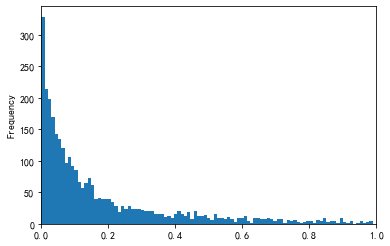

In [258]:
c_df[c_df.完成百分比 < 1].完成百分比.plot.hist(bins=100, xlim=[0, 1])

<AxesSubplot:ylabel='Frequency'>

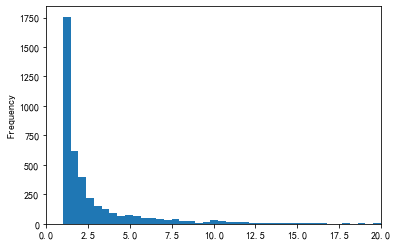

In [259]:
c_df[c_df.完成百分比 >= 1].完成百分比.plot.hist(bins=5000, xlim=[0, 20])

### 1.4 项目发起人的经验

直接经验: 发起项目的数量、类别数量

间接经验：资助项目的数量

In [32]:
company = db.companies

In [33]:
exp_dict = {'项目编号': [], '已发起项目数':[], '已支持项目数': []}
a = 0
for p_id in c_df.index:
    item = company.find_one({"发起项目": p_id})
    if item:
        num_launch = np.sum(np.array([int(x) for x in item["发起项目"]]) < int(p_id))  # 按项目编号计算当前p_id之前发起过的项目数量
        num_support = np.sum(np.array([int(x) for x in item["支持项目"]]) < int(p_id))  # 按项目编号计算当前p_id之前发起过的项目数量
        exp_dict['项目编号'].append(p_id)
        exp_dict['已发起项目数'].append(num_launch)
        exp_dict['已支持项目数'].append(num_support)
    else:
        a += 1

In [34]:
company.find_one({'公司名称': '郑州封之匠电子商务有限公司'})

In [35]:
exp_df = pd.DataFrame(exp_dict, columns=['已发起项目数', '已支持项目数'], index=exp_dict['项目编号'])

In [36]:
exp_df[exp_df.已发起项目数 > 0].describe()

,已发起项目数,已支持项目数
count,1713.000000,1713.000000
mean,2.779918,0.466433
std,1.886070,1.165689
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,4.000000,0.000000
max,7.000000,8.000000


In [37]:
company.count_documents({})

4836

In [38]:
u_df = pd.merge(c_df, exp_df, how="left", left_index=True, right_index=True, sort=True)  # 先合并

In [260]:
u_df[pd.isna(u_df.已发起项目数)][['众筹期限', '公司名称', '目标金额', '已发起项目数', '已支持项目数']]

,众筹期限,公司名称,目标金额,已发起项目数,已支持项目数
100034,45,郑州封之匠电子商务有限公司,30000,NaN,NaN
100081,40,上海宸赞电子有限公司,200000,NaN,NaN
100127,45,味觉方舟（深圳）科技有限公司,30000,NaN,NaN
100162,30,福州广诚行贸易有限公司,30000,NaN,NaN
100163,40,福州广诚行贸易有限公司,30000,NaN,NaN
...,...,...,...,...,...
99693,30,泛音电动工具（太仓）有限公司,200000,NaN,NaN
99848,20,杭州绿宜贸易有限公司,10000,NaN,NaN
99906,45,福建聚融实业有限公司,200000,NaN,NaN
99927,60,阿克苏珍玉果电子商务有限公司,10000,NaN,NaN


In [40]:
company.find_one({'已发起项目数': '107555'})

In [41]:
c_df.loc['107555']

状态                                            项目成功
众筹期限                                            45
公司名称                                 郑州封之匠电子商务有限公司
公司地址               河南郑州市新郑市  人民路168号西亚斯御璟2号楼2-19室。
公司工作时间                             工作日 09:00-18:00
公司电话                                   15617971082
发起人名称                                       华匠左藏总舵
发起人链接        /funderCenter.action?flag=2&id=107555
所属类别                                          文化传承
目标金额                                         10000
项目名称                                华匠左藏x宋隐x吉祥五福建盏
状态变换时间0-1               2018-11-29 00:00:03.231000
状态变换时间1-2               2018-11-30 12:00:03.391000
状态变换时间2-3               2019-01-14 12:00:03.959000
状态变换时间3-4               2019-03-12 06:00:08.543000
评论数量                                          11.0
档位数量                                             8
筹集金额                                         17423
关注数                                             77
支持者数                           

In [43]:
c_df.columns

Index(['状态', '众筹期限', '公司名称', '公司地址', '公司工作时间', '公司电话', '发起人名称', '发起人链接',
       '所属类别', '目标金额', '项目名称', '状态变换时间0-1', '状态变换时间1-2', '状态变换时间2-3',
       '状态变换时间3-4', '评论数量', '档位数量', '筹集金额', '关注数', '支持者数', '点赞数', '完成百分比'],
      dtype='object')

### 1.5 合并和转换数据

In [404]:
# 以所有在库的项目为左表进行连接，没有找到，则对应值留空
s_df = pd.merge(c_df, df2, how="left", left_index=True, right_index=True, sort=True)  # 先合并

- 处理失败项目的时间跨度

In [405]:
indices = pd.isna(s_df.绝对时间跨度) 
s_df.loc[indices, '绝对时间跨度'] = s_df[indices]['众筹期限'] * 3600 * 24
s_df.loc[indices, '相对时间跨度'] = 1

- 合并主页呈现数据

In [406]:
# dt = pd.merge(s_df, front_df, how="left", left_index=True, right_index=True, sort=True)  # 时长
dt = pd.merge(front_df, s_df, how="left", left_index=True, right_index=True, sort=True)
dt = pd.merge(dt, begin_front_df, how="left", left_index=True, right_index=True, sort=True)  # 初次呈现
dt.loc[:, dt.columns] = dt[dt.columns].fillna(0) # 填充未在主页出现的项目为0

- 推荐页面总时长column

In [407]:
dt["推荐页面总时长"] = dt[keys].sum(axis=1)

- 轮播column

In [408]:
dt["轮播"] = dt[["轮播_rt", "轮播_rbl", "轮播_rbl", "轮播_rbr"]].sum(axis=1)

- 轮播版块出现的最早时间

In [409]:
def get_min_excp_zero(x):
    '''
    获取除0之外的最小值
    '''
    a = [i for i in x if i != 0]
    if a:
        return np.min(a)
    else:
        return 0

In [410]:
begin_轮播_cols = ["begin_轮播_rt", "begin_轮播_rbl", "begin_轮播_rbl", "begin_轮播_rbr"]
dt["begin_轮播"] = dt[begin_轮播_cols].apply(axis=1, func=get_min_excp_zero)
for u in ("_完成百分比", "_筹集金额", "_关注数", "_支持者数"):
    dt["begin_轮播" + u] = dt[[c+u for c in begin_轮播_cols]].apply(axis=1, func=get_min_excp_zero)

In [411]:
dt.begin_轮播[dt.begin_轮播 > 0]

104000        101.999906
107096        956.979945
107474        647.999591
107993        323.999311
108488        768.483562
                 ...    
1840735880    131.999893
1841765716    119.999736
1842109924     95.999957
1842435249     30.000094
1842435347     35.999816
Name: begin_轮播, Length: 670, dtype: float64

- 在各类别版面上出现的总时间

In [412]:
dt["各类版块总时长"] = dt[['demostr_proj_健康出行_左上大图',
     'demostr_proj_健康出行_其它图',
     'demostr_proj_生活美学_左上大图',
     'demostr_proj_生活美学_其它图',
     'demostr_proj_文化艺术_左上大图',
     'demostr_proj_文化艺术_其它图',
     'demostr_proj_惠民扶贫_左上大图',
     'demostr_proj_惠民扶贫_其它图',
     'demostr_proj_美食市集_左上大图',
     'demostr_proj_美食市集_其它图',
     'demostr_proj_新奇酷玩_左上大图',
     'demostr_proj_新奇酷玩_其它图']].sum(axis=1)  # 各类版面的总呈现时长

- 在各类版块出现的最早时间

In [413]:
begin_demo_cols = ['begin_demostr_proj_健康出行_左上大图',
     'begin_demostr_proj_健康出行_其它图',
     'begin_demostr_proj_生活美学_左上大图',
     'begin_demostr_proj_生活美学_其它图',
     'begin_demostr_proj_文化艺术_左上大图',
     'begin_demostr_proj_文化艺术_其它图',
     'begin_demostr_proj_惠民扶贫_左上大图',
     'begin_demostr_proj_惠民扶贫_其它图',
     'begin_demostr_proj_美食市集_左上大图',
     'begin_demostr_proj_美食市集_其它图',
     'begin_demostr_proj_新奇酷玩_左上大图',
     'begin_demostr_proj_新奇酷玩_其它图']

In [414]:
dt["begin_各类版块"] = dt[begin_demo_cols].apply(axis=1, func=get_min_excp_zero)
for u in ("_完成百分比", "_筹集金额", "_关注数", "_支持者数"):
    dt["begin_各类版块"+u] = dt[[c+u for c in begin_demo_cols]].apply(axis=1, func=get_min_excp_zero)

- 构建是否出现在对应版面的0-1变量：是否出现可反映平台方对众筹项目前景的认可

In [418]:
dt['is_即将上架'] = dt.即将上架.apply(lambda x: 1 if x > 0 else 0)
dt['is_最新上架'] = dt.最新上架.apply(lambda x: 1 if x > 0 else 0)
dt['is_轮播'] = dt.轮播.apply(lambda x: 1 if x > 0 else 0)
dt['is_热门推荐'] = dt.热门推荐.apply(lambda x: 1 if x > 0 else 0)
dt['is_各类版块总时长'] = dt.各类版块总时长.apply(lambda x: 1 if x > 0 else 0)
dt['is_即将结束'] = dt.即将结束.apply(lambda x: 1 if x > 0 else 0)

## 2 保存数据

In [419]:
dt.describe()

,轮播_left,即将上架,demostr_proj_健康出行_左上大图,demostr_proj_健康出行_其它图,demostr_proj_生活美学_左上大图,demostr_proj_生活美学_其它图,demostr_proj_文化艺术_左上大图,demostr_proj_文化艺术_其它图,demostr_proj_惠民扶贫_左上大图,demostr_proj_惠民扶贫_其它图,...,begin_各类版块_完成百分比,begin_各类版块_筹集金额,begin_各类版块_关注数,begin_各类版块_支持者数,is_即将上架,is_最新上架,is_轮播,is_热门推荐,is_各类版块总时长,is_即将结束
count,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,...,4670.000000,4.670000e+03,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000
mean,13.503017,35.596447,16.194505,42.210739,24.168654,72.598316,15.627662,42.237758,17.719576,54.196867,...,66.382655,1.825536e+04,192.251178,92.542612,0.892934,0.587152,0.144754,0.085225,0.623769,0.639186
std,86.496200,34.021721,107.186035,177.282888,136.869748,235.445347,106.277419,186.962560,107.416331,198.426432,...,758.116938,7.991182e+04,591.479877,424.178699,0.309231,0.492399,0.351890,0.279246,0.484491,0.480288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,11.999722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,23.999722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.211500e+03,16.000000,9.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,52.000000,1.196800e+04,55.000000,48.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1680.005556,305.999722,1643.999167,1793.993333,2009.999722,2082.000000,1506.000278,2009.999444,1433.999722,1866.000000,...,50640.000000,2.031602e+06,18320.000000,9738.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [420]:
dt.to_csv("data.csv")

In [386]:
l = pd.read_csv("data.csv", index_col=0)
l.describe()

,轮播_left,即将上架,demostr_proj_健康出行_左上大图,demostr_proj_健康出行_其它图,demostr_proj_生活美学_左上大图,demostr_proj_生活美学_其它图,demostr_proj_文化艺术_左上大图,demostr_proj_文化艺术_其它图,demostr_proj_惠民扶贫_左上大图,demostr_proj_惠民扶贫_其它图,...,begin_各类版块_完成百分比,begin_各类版块_筹集金额,begin_各类版块_关注数,begin_各类版块_支持者数,is_即将上架,is_最新上架,is_轮播,is_热门推荐,is_各类版块总时长,is_即将结束
count,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,...,6033.000000,6.033000e+03,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000
mean,10.763645,33.058751,12.915552,35.512065,20.248894,61.210428,12.550502,35.106965,13.855531,42.692417,...,52.039284,1.446440e+04,167.552296,73.221449,0.764296,0.509862,0.118349,0.067462,0.529587,0.495442
std,76.838452,36.361046,95.116779,162.778083,124.625575,215.793958,95.224760,170.517532,95.149371,177.234152,...,667.534806,7.072137e+04,542.861707,375.552884,0.424473,0.499944,0.323048,0.250842,0.499165,0.500021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.996944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.250000e+02,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,34.000000,8.186000e+03,43.000000,32.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1680.005556,353.999722,1643.999167,1793.993333,2009.999722,2082.000000,1506.000278,2009.999444,1433.999722,1866.000000,...,50640.000000,2.031602e+06,18320.000000,9738.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
